In [1]:
! pip install -q "diffusers==0.30.3" "transformers==4.44.2" "peft==0.12.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 16.8 MB/s eta 0:00:00


In [2]:
import torch
from diffusers import AutoPipelineForInpainting, LCMScheduler, DiffusionPipeline
from diffusers.utils import load_image, make_image_grid

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Inpainting

###### To use LCM-LoRAs for inpainting, you need to replace the scheduler with the **LCMScheduler** and load the LCM-LoRA weights with the **load_lora_weights()**

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/4 [00:00<?, ?it/s]

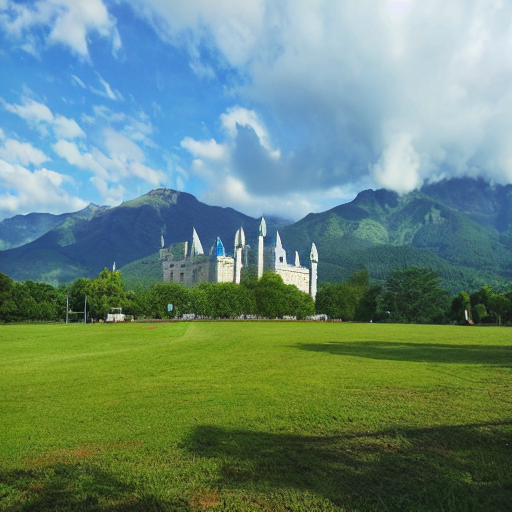

In [4]:
pipe = AutoPipelineForInpainting.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")

pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

pipe.load_lora_weights("latent-consistency/lcm-lora-sdv1-5")

init_image = load_image("https://www.sab.ac.lk/app/icaps/assets/images/about/conference1.jpg")
mask_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint_mask.png")

prompt = "concept art digital painting of an elven castle, inspired by lord of the rings, highly detailed, 8k"
generator = torch.manual_seed(0)
image = pipe(
    prompt=prompt,
    image=init_image,
    mask_image=mask_image,
    generator=generator,
    num_inference_steps=4,
    guidance_scale=4,
).images[0]
image

# Adapters

In [5]:
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    variant="fp16",
    torch_dtype=torch.float16
).to("cuda")

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


pytorch_lora_weights.safetensors:   0%|          | 0.00/394M [00:00<?, ?B/s]

papercut.safetensors:   0%|          | 0.00/341M [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

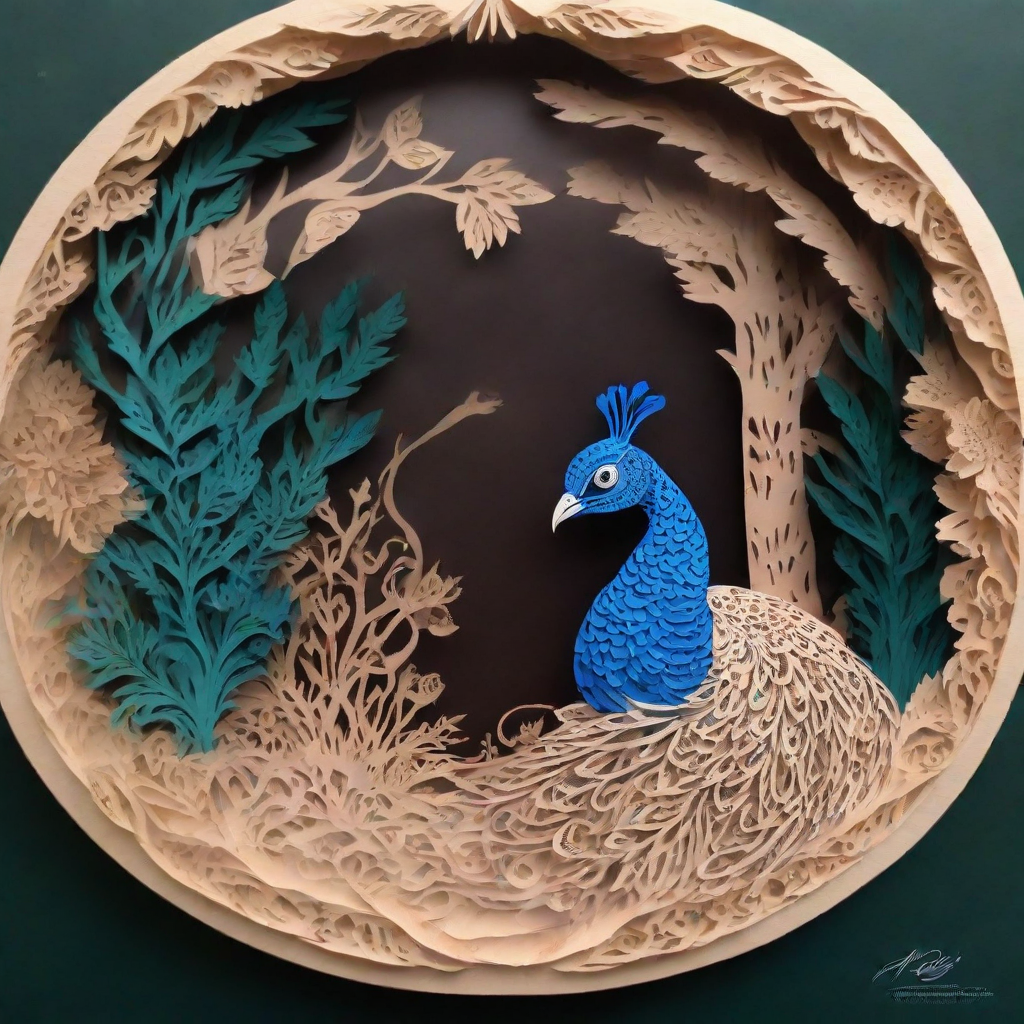

In [6]:
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl", adapter_name="lcm")
pipe.load_lora_weights("TheLastBen/Papercut_SDXL", weight_name="papercut.safetensors", adapter_name="papercut")

pipe.set_adapters(["lcm", "papercut"], adapter_weights=[1.0, 0.8])

prompt = "papercut, a cute peacock"
generator = torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=4, guidance_scale=1, generator=generator).images[0]
image